In [79]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import zipfile
from tqdm import tqdm
from pathlib import Path
plt.style.use('dark_background')

### 2 Fundamental Principles of Holography 
- **Dr. Ulf Schnars, Prof. Dr. Werner Jueptner (auth.) - Digital Holography_ Digital Hologram Recording, Numerical Reconstruction, and Related Techniques (2005, Springer) [10.1007_b138284] - libgen.li.pdf**

In [ ]:
# Paths
NOTEBOOK_DIR = Path().resolve()
BASE_DIR = NOTEBOOK_DIR.parents[1]
DATASET_OUPUT_FOLDER = BASE_DIR  /  "data" / "1-all-noise"
HEIGHT , WIDTH = 256 ,256
IMAGE_SIZE = (HEIGHT , WIDTH)
import sys
sys.path.append(str(BASE_DIR))
import helper
DATASET_OUPUT_FOLDER

WindowsPath('C:/Users/SriRam.A/Documents/sr_proj/Hologram/data')

1. RANDOMIZED interferogram generator

In [81]:
import numpy as np
import matplotlib.pyplot as plt
N = 256
x = np.linspace(-1, 1, N) # 1-D vector of N point ranging from -1 to 1
y = np.linspace(-1, 1, N) # 1-D vector of N point ranging from -1 to 1
print("x.shape",x.shape)
print("y.shape",y.shape)

x.shape (256,)
y.shape (256,)


X:
[[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]

Y:
[[10. 10. 10.]
 [11. 11. 11.]
 [12. 12. 12.]]

Meshgrid makes :
|      | x=0    | x=1    | x=2    |
| ---- | ------ | ------ | ------ |
| y=10 | (0,10) | (1,10) | (2,10) |
| y=11 | (0,11) | (1,11) | (2,11) |
| y=12 | (0,12) | (1,12) | (2,12) |


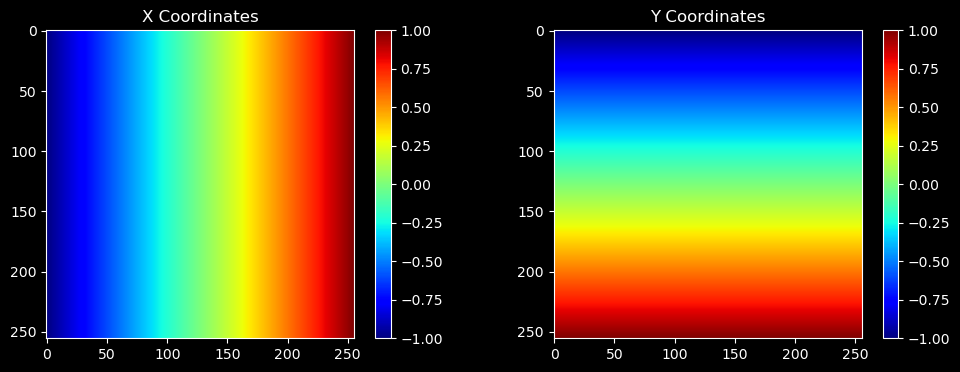

In [82]:
X, Y = np.meshgrid(x,y)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(X, cmap='jet')
plt.colorbar()
plt.title("X Coordinates")

plt.subplot(1,2,2)
plt.imshow(Y, cmap='jet')
plt.colorbar()
plt.title("Y Coordinates")
plt.show()

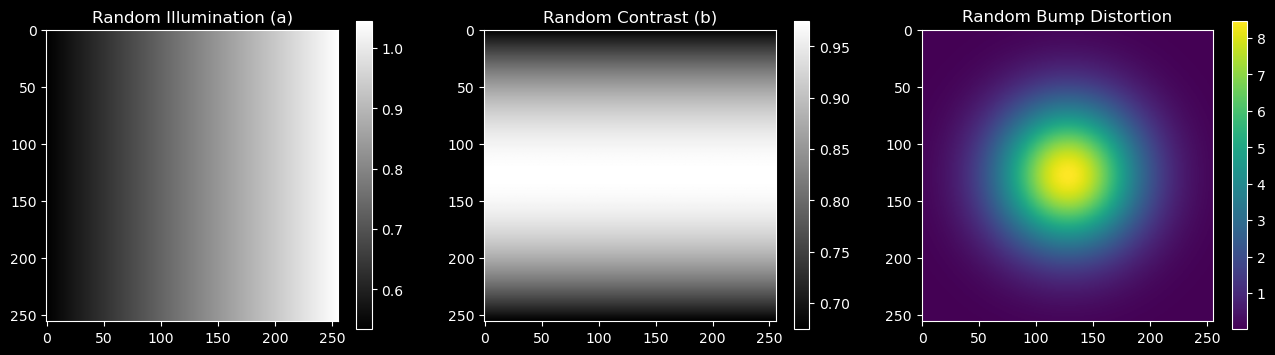

In [83]:
base_illumination = np.random.uniform(0.4, 0.8)  # picks a base illumination.
grad_along_X = np.random.uniform(-0.3, 0.3)*X # adds a gradient along X, so one side is slightly brighter.
a = base_illumination + grad_along_X
b = np.random.uniform(0.4, 1.0) - 0.3*(Y**2) # Random contrast
amp = np.random.uniform(0, 10)
sigma = np.random.uniform(0.1, 0.5)
bump = amp * np.exp(-(X**2 + Y**2) / sigma) #Random Bump

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(a, cmap='gray')
plt.colorbar()
plt.title("Random Illumination (a)")

plt.subplot(1,3,2)
plt.imshow(b, cmap='gray')
plt.colorbar()
plt.title("Random Contrast (b)")

plt.subplot(1,3,3)
plt.imshow(bump, cmap='viridis')
plt.colorbar()
plt.title("Random Bump Distortion")
plt.show()

In [84]:
#  These control the number of fringes horizontally (fx) and vertically (fy)
fx = np.random.uniform(5, 40)
fy = np.random.uniform(5, 40)
print(f"Random frequencies: fx={fx:.2f}, fy={fy:.2f}")

Random frequencies: fx=22.09, fy=16.11



## 💡 Two-Beam Interference Intensity

The resulting **intensity ($I$)** at a point where two coherent beams interfere is given by the superposition principle:

$$I = I_a + I_b + 2\sqrt{I_a I_b} \cos(\delta)$$

Where:

  * $I_a, I_b$ are the intensities of the individual beams.
  * $\delta$ is the **phase difference** between the beams at that point.

### Simplified and Normalized Form

In many cases, especially when the individual beam intensities are assumed to be approximately equal ($I_a \approx I_b$) and the total intensity is normalized, the formula simplifies to a form highlighting the background and the fringe contrast:

$$I \approx a + b \cos(\delta)$$

This is often represented in code for modeling purposes as:

```python
I = a + b * np.cos(phi)
```

Where:

  * $a$ is the **background illumination** (the average intensity).
  * $b$ is the **fringe contrast** (related to the visibility of the interference pattern).
  * $\phi$ (or $\delta$) is the phase difference.

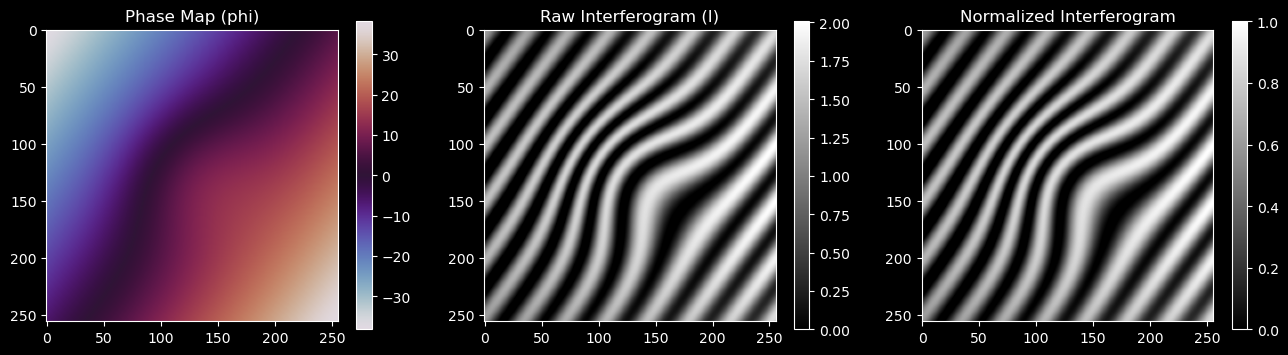

In [85]:
phi = fx*X + fy*Y + bump # Phase map
I = a + b * np.cos(phi)
I = np.clip(I, 0, None)  # ensures all values >= 0 since I cannot be negative

I_norm = (I - I.min()) / (I.max() - I.min()) # Normalize

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(phi, cmap='twilight')
plt.colorbar()
plt.title("Phase Map (phi)")

plt.subplot(1,3,2)
plt.imshow(I, cmap='gray')
plt.colorbar()
plt.title("Raw Interferogram (I)")

plt.subplot(1,3,3)
plt.imshow(I_norm, cmap='gray')
plt.colorbar()
plt.title("Normalized Interferogram")
plt.show()


In [86]:
def generate_interferogram_random(N=256):
    X, Y = np.meshgrid(np.linspace(-1,1,N), np.linspace(-1,1,N))
    # Random illumination
    a = np.random.uniform(0.4, 0.8) + np.random.uniform(-0.3, 0.3)*X
    # Random contrast
    b = np.random.uniform(0.4, 1.0) - 0.3*(Y**2)
    # Random carrier frequencies
    fx = np.random.uniform(5, 40)
    fy = np.random.uniform(5, 40)
    # Random bump distortion
    amp = np.random.uniform(0, 10)
    sigma = np.random.uniform(0.1, 0.5)
    bump = amp * np.exp(-(X**2 + Y**2) / sigma)
    # Phase map
    phi = fx*X + fy*Y + bump
    # Interferogram
    I = a + b*np.cos(phi)
    I = np.clip(I, 0, None)  # ensures all values >= 0 since I cannot be negative
    # Normalize 0–1
    I = (I - I.min()) / (I.max() - I.min())
    return I

 2. Raw noise mixture
- *AWGN (Additive White Gaussian Noise)* : tiny random brightness fluctuations added independently to each pixel..
- *Speckle Noise (Multiplicative)* : Each pixel of the interferogram is multiplied by random noise. Dark areas → less effect, bright areas → bigger fluctuations
- *Poisson Noise (Photon Counting Noise)* : Models shot noise, common in optical sensors

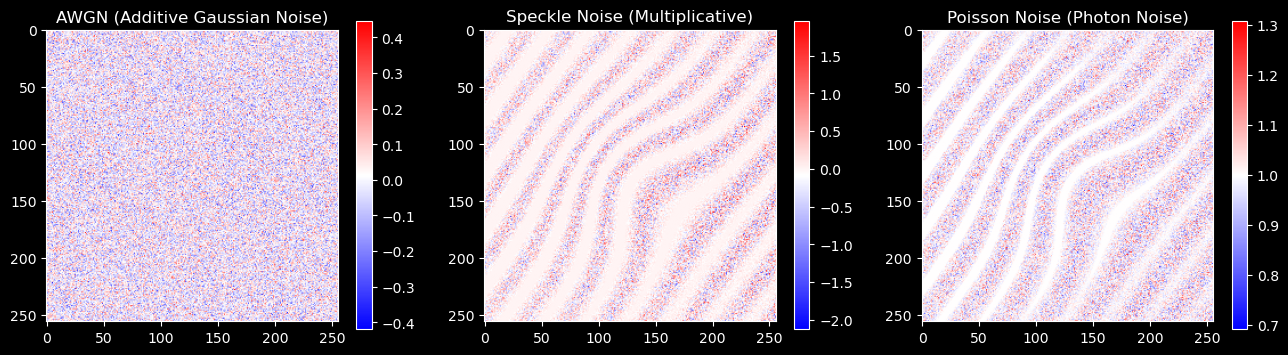

In [87]:
sigma = 0.1
awgn = np.random.normal(0, sigma, I.shape)

alpha = 0.3
speckle = I * np.random.normal(0, alpha, I.shape)

peak = 300
poisson = np.random.poisson(I * peak) / peak - I + 1

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(awgn, cmap='bwr')
plt.colorbar()
plt.title("AWGN (Additive Gaussian Noise)")

plt.subplot(1,3,2)
plt.imshow(speckle, cmap='bwr')
plt.colorbar()
plt.title("Speckle Noise (Multiplicative)")

plt.subplot(1,3,3)
plt.imshow(poisson, cmap='bwr')
plt.colorbar()
plt.title("Poisson Noise (Photon Noise)")
plt.show()


In [88]:
def raw_noise(I, sigma=0.1, alpha=0.3, peak=300):
    awgn = np.random.normal(0, sigma, I.shape)
    speckle = I * np.random.normal(0, alpha, I.shape)
    poisson = np.random.poisson(I * peak) / peak - I
    return awgn + speckle + poisson

3. SNR-controlled noise addition


In [89]:
def add_noise_snr(I_clean, snr_db):
    noise_raw = raw_noise(I_clean)
    signal_power = np.mean(I_clean**2)
    noise_power_raw = np.mean(noise_raw**2)
    target_noise_power = signal_power / (10**(snr_db/10))
    scale = np.sqrt(target_noise_power / noise_power_raw)
    noise_final = noise_raw * scale
    I_noisy = np.clip(I_clean + noise_final, 0, 1)
    return I_noisy, noise_final

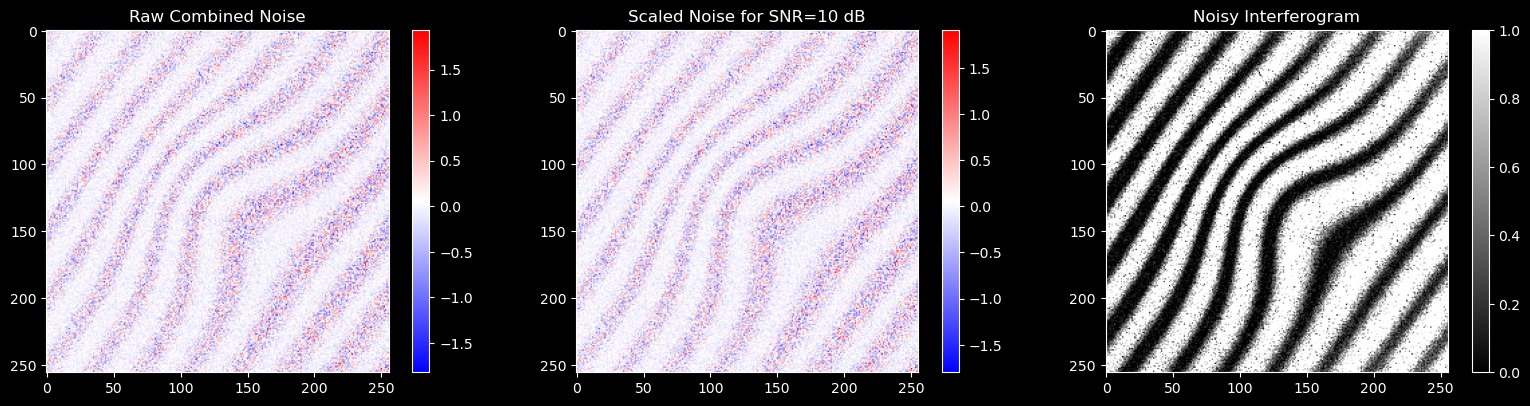

In [ ]:
noise_raw = raw_noise(I)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(noise_raw, cmap='bwr')
plt.colorbar()
plt.title("Raw Combined Noise")

snr_db = 10  # example SNR in dB

signal_power = np.mean(I**2)
noise_power_raw = np.mean(noise_raw**2)
target_noise_power = signal_power / (10**(snr_db/10))
scale = np.sqrt(target_noise_power / noise_power_raw)

noise_scaled = noise_raw * scale

plt.subplot(1,3,2)
plt.imshow(noise_scaled, cmap='bwr')
plt.colorbar()
plt.title(f"Scaled Noise for SNR={snr_db} dB")

I_noisy = I + noise_scaled
I_noisy = np.clip(I + noise_scaled, 0, 1) # since I > 0

plt.subplot(1,3,3)
plt.imshow(I_noisy, cmap='gray')
plt.colorbar()
plt.title("Noisy Interferogram")

plt.tight_layout()
plt.show()


 4. Dataset generator


In [ ]:
def generate_dataset(
        save_dir: str | Path = "dataset_output",
        N=256,
        snr_values=np.arange(-5, 30, 5),
        samples_per_snr=100,
    ):
    """
    Generates a dataset of clean (input) and noisy (target) interferograms,
    organizing them into separate 'input' and 'target' subdirectories,
    with SNR included in the filename.
    """
    # Use Path() for the base directory
    base_path = Path(save_dir)
    base_path.mkdir(exist_ok=True)

    # Define the separate input and target directories
    input_dir = base_path / "input"
    target_dir = base_path / "target"

    # Create the input and target directories
    input_dir.mkdir(exist_ok=True)
    target_dir.mkdir(exist_ok=True)

    for snr_db in snr_values:
        print(f"\nGenerating SNR {snr_db} dB")
        
        for i in tqdm(range(samples_per_snr)):
            # Assuming these functions are available
            I_clean = generate_interferogram_random(N)
            I_noisy, total_noise = add_noise_snr(I_clean, snr_db)
            
            # Standardize the SNR string for filename
            snr_str = f"SNR_{snr_db}dB"
            
            # --- Save Clean Image to 'input' directory ---
            # Filename format: SNR_-5dB_clean_0.png
            clean_filename = f"{snr_str}_clean_{i}.png"
            cv2.imwrite(str(target_dir / clean_filename),
                        (I_clean * 255).astype(np.uint8))
            
            # --- Save Noisy Image to 'target' directory ---
            # Filename format: SNR_-5dB_noisy_0.png
            noisy_filename = f"{snr_str}_noisy_{i}.png"
            cv2.imwrite(str(input_dir / noisy_filename),
                        (I_noisy * 255).astype(np.uint8))

    print("\nDataset Generation Complete")

In [94]:
DATASET_OUPUT_FOLDER

WindowsPath('C:/Users/SriRam.A/Documents/sr_proj/Hologram/data')

In [95]:
generate_dataset(
    save_dir = DATASET_OUPUT_FOLDER,
    samples_per_snr=200,   
)


Generating SNR -5 dB


100%|██████████| 200/200 [00:02<00:00, 89.32it/s]



Generating SNR 0 dB


100%|██████████| 200/200 [00:02<00:00, 82.87it/s]



Generating SNR 5 dB


100%|██████████| 200/200 [00:03<00:00, 63.43it/s]



Generating SNR 10 dB


100%|██████████| 200/200 [00:03<00:00, 60.55it/s]



Generating SNR 15 dB


100%|██████████| 200/200 [00:03<00:00, 62.71it/s]



Generating SNR 20 dB


100%|██████████| 200/200 [00:03<00:00, 64.68it/s]



Generating SNR 25 dB


100%|██████████| 200/200 [00:03<00:00, 61.15it/s]


Dataset Generation Complete
